In [1]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import sys

sys.path.append('/home/vdhanraj/llama/llama3/llama')
sys.path.append('/home/vdhanraj/llama/llama3')

import openai
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import time
from pathlib import Path
from typing import List, Optional, Tuple, TypedDict

import torch.nn.functional as F
from fairscale.nn.model_parallel.initialize import (
    get_model_parallel_rank,
    initialize_model_parallel,
    model_parallel_is_initialized,
)
from fairscale.nn.model_parallel.layers import (
    ColumnParallelLinear,
    RowParallelLinear,
    VocabParallelEmbedding,
)

from llama.model import ModelArgs, Transformer, RMSNorm
from llama.tokenizer import ChatFormat, Dialog, Message, Tokenizer
from llama.generation import sample_top_p
from llama.EncoderNetworks import Encoder, Decoder, Encoder_Deep, Decoder_Deep, LastTokenTransformer

from typing import List, Optional
import fire

from llama import Dialog, Llama

from IPython.display import Markdown

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import wandb

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from llama.SP_engine import SemanticEngine
import plotly.graph_objects as go
import seaborn as sns

from nengo.dists import UniformHypersphere

from graphviz import Digraph
import torch
from torch.autograd import Variable
from torchviz import make_dot
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler

from datetime import datetime



In [ ]:
#ckpt_dir = "Meta-Llama-3-8B-Instruct"
ckpt_dir = "/home/vdhanraj/.llama/checkpoints/Llama3.1-8B-Instruct"
#tokenizer_path = "Meta-Llama-3-8B-Instruct/tokenizer.model"
tokenizer_path = "/home/vdhanraj/.llama/checkpoints/Llama3.1-8B-Instruct/tokenizer.model"
max_seq_len = 10000
max_batch_size = 2 # set to 1 if doing CoT to not overload the GPU, otherwise can handle up to 4
model_parallel_size = 1

top_p = 0.9
temperature = 0
max_gen_len = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 4090


In [3]:
os.environ['RANK'] = "0"
os.environ['WORLD_SIZE'] = "1"
os.environ['MASTER_ADDR'] = "127.0.0.2"
os.environ['MASTER_PORT'] = "29502"
os.environ['LOCAL_RANK']  = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


generator = Llama.build(
    ckpt_dir=ckpt_dir,
    tokenizer_path=tokenizer_path,
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
)
self = generator

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/home/vdhanraj/anaconda3/envs/torch/lib/python3.8/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Loaded in 15.22 seconds


In [4]:
import math
import num2words as n2w
from word2number import w2n

def generate_dialog(complexity=8, samples=1, problem_type="addition", cot=False, string_nums=False):
    #x = np.random.randint(low=10**(complexity), high=10**(complexity+1), size=samples)
    x = np.random.randint(low=1, high=10**(complexity+1), size=samples)
    #y = np.random.randint(low=10**(complexity), high=10**(complexity+1), size=samples)
    y = np.random.randint(low=1, high=10**(complexity+1), size=samples)
    
    temp_x = []
    temp_y = []
    for n in range(samples):
        x[n], y[n] = max(x[n], y[n]), min(x[n], y[n])
        if string_nums:
            temp_x += [n2w.num2words(x[n])]
            temp_y += [n2w.num2words(y[n])]
    if string_nums:
        x, y, temp_x, temp_y = np.array(temp_x), np.array(temp_y), x, y

    #example_x1, example_y1 = np.random.randint(low=10**(complexity), high=10**(complexity+1)), np.random.randint(low=10**(complexity), high=10**(complexity+1))
    example_x1, example_y1 = np.random.randint(low=1, high=10**(complexity+1)), np.random.randint(low=1, high=10**(complexity+1))
    #example_x2, example_y2 = np.random.randint(low=10**(complexity), high=10**(complexity+1)), np.random.randint(low=10**(complexity), high=10**(complexity+1))
    example_x2, example_y2 = np.random.randint(low=1, high=10**(complexity+1)), np.random.randint(low=1, high=10**(complexity+1))
    example_x1, example_y1 = max(example_x1, example_y1), min(example_x1, example_y1)
    example_x2, example_y2 = max(example_x2, example_y2), min(example_x2, example_y2)
    
    if string_nums:
        example_x1, example_y1 = n2w.num2words(example_x1), n2w.num2words(example_y1)
        example_x2, example_y2 = n2w.num2words(example_x2), n2w.num2words(example_y2)

    if string_nums:
        conv = lambda x: w2n.word_to_num(str(x))
        conv_inv = lambda x: n2w.num2words(int(x))

    else:
        conv = lambda x: x
        conv_inv = lambda x: x


    dialog: List[Dialog] = []

    if type(problem_type) == type([]):
        problem_type = random.choice(problem_type)
    
    if problem_type == "random":
        problem_type = random.choice(["addition", "multiplication", "division", "modulo", "gcd", "lcm", "square_mod", "bitwise_and", "bitwise_xor", "bitwise_or"])

    for n in range(samples):
        if cot:
            dialog += [
                [
                    {"role": "system", "content": 
                     "You are a math-solving assistant. Always explain your reasoning step by step. "
                     "Regardless of the steps taken, ensure the final answer is clearly marked with 'Final Answer: x'."
                    },
                ]
            ]
        else:
            dialog += [
                [
                    {"role": "system", "content": 
                     "You are a math solving helper. Don't use any commas in your output, "
                     "and always answer problems according to the format of previous answers."
                    },
                ]
            ]

        if problem_type == "addition":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} plus {y[n]}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} plus {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1) + conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} plus {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2) + conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} plus {y[n]}?"},
                ]

        elif problem_type == "multiplication":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} times {y[n]} mod {10**(complexity+1)}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} times {example_y1} mod {10**(complexity+1)}?"},
                    {"role": "assistant", "content": f"{conv_inv((conv(example_x1) * conv(example_y1)) % 10**(complexity+1))}"},
                    {"role": "user", "content": f"What is {example_x2} times {example_y2} mod {10**(complexity+1)}?"},
                    {"role": "assistant", "content": f"{conv_inv((conv(example_x2) * conv(example_y2)) % 10**(complexity+1))}"},
                    {"role": "user", "content": f"What is {x[n]} times {y[n]} mod {10**(complexity+1)}?"},
                ]

        elif problem_type == "division":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} // {y[n]}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} // {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1)//conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} // {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2)//conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} // {y[n]}?"},
                ]

        elif problem_type == "modulo":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} mod {y[n]}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} mod {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1) % conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} mod {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2) % conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} mod {y[n]}?"},
                ]

        elif problem_type == "gcd":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is the GCD of {x[n]} and {y[n]}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is the GCD of {example_x1} and {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(np.gcd(conv(example_x1), conv(example_y1)))}"},
                    {"role": "user", "content": f"What is the GCD of {example_x2} and {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(np.gcd(conv(example_x2), conv(example_y2)))}"},
                    {"role": "user", "content": f"What is the GCD of {x[n]} and {y[n]}?"},
                ]

        elif problem_type == "lcm":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is the LCM of {x[n]} and {y[n]} mod {10**(complexity+1)}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is the LCM of {example_x1} and {example_y1} mod {10**(complexity+1)}?"},
                    {"role": "assistant", "content": f"{conv_inv(np.lcm(conv(example_x1), conv(example_y1)) % 10**(complexity+1))}"},
                    {"role": "user", "content": f"What is the LCM of {example_x2} and {example_y2} mod {10**(complexity+1)}?"},
                    {"role": "assistant", "content": f"{conv_inv(np.lcm(conv(example_x2), conv(example_y2)) % 10**(complexity+1))}"},
                    {"role": "user", "content": f"What is the LCM of {x[n]} and {y[n]} mod {10**(complexity+1)}?"},
                ]

        elif problem_type == "square_mod":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]}^2 mod {y[n]}?"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1}^2 mod {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv((conv(example_x1))**2 % conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2}^2 mod {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv((conv(example_x2))**2 % conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]}^2 mod {y[n]}?"},
                ]

        elif problem_type == "bitwise_and":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} AND {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} AND {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1) & conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} AND {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2) & conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} AND {y[n]}?"},
                ]

        elif problem_type == "bitwise_xor":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} XOR {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} XOR {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1) ^ conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} XOR {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2) ^ conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} XOR {y[n]}?"},
                ]
        elif problem_type == "bitwise_or":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} OR {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} OR {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x1) | conv(example_y1))}"},
                    {"role": "user", "content": f"What is {example_x2} OR {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(conv(example_x2) | conv(example_y2))}"},
                    {"role": "user", "content": f"What is {x[n]} OR {y[n]}?"},
                ]
        elif problem_type == "bitwise_nor":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} NOR {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} NOR {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x1) | conv(example_y1)))}"},
                    {"role": "user", "content": f"What is {example_x2} NOR {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x2) | conv(example_y2)))}"},
                    {"role": "user", "content": f"What is {x[n]} NOR {y[n]}?"},
                ]
        elif problem_type == "bitwise_nand":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} NAND {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} NAND {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x1) & conv(example_y1)))}"},
                    {"role": "user", "content": f"What is {example_x2} NAND {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x2) & conv(example_y2)))}"},
                    {"role": "user", "content": f"What is {x[n]} NAND {y[n]}?"},
                ]
        elif problem_type == "bitwise_nxor":
            if cot:
                dialog[n] += [
                    {"role": "user", "content": f"Solve the following problem step by step: " 
                     f"What is {x[n]} NXOR {y[n]}? Remember to convert your final answer back to decimal"},
                ]
            else:
                dialog[n] += [
                    {"role": "user", "content": f"What is {example_x1} NXOR {example_y1}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x1) ^ conv(example_y1)))}"},
                    {"role": "user", "content": f"What is {example_x2} NXOR {example_y2}?"},
                    {"role": "assistant", "content": f"{conv_inv(~(conv(example_x2) ^ conv(example_y2)))}"},
                    {"role": "user", "content": f"What is {x[n]} NXOR {y[n]}?"},
                ]


    return dialog, x, y, problem_type


In [5]:
def generate_non_math_dialog(samples=1, topic="philosophy", cot=False):
    example_questions = {
        "philosophy": [
            ("Is the Ship of Theseus still the same ship after all parts are replaced?", "This is a classic thought experiment questioning the nature of identity."),
            ("What is the meaning of life according to existentialism?", "Existentialists argue that individuals create their own meaning through choices and actions."),
            ("Can free will exist in a deterministic universe?", "This question explores the compatibility of determinism with the concept of free will."),
            ("What distinguishes knowledge from belief?", "Knowledge typically requires justified true belief, while belief does not necessarily require justification."),
            ("Does morality exist independently of humans?", "This question examines moral realism versus moral anti-realism.")
        ],
        "ethics": [
            ("Is it morally acceptable to lie to protect someone's feelings?", "This involves balancing honesty with the value of kindness."),
            ("Should animals have the same rights as humans?", "This raises questions about sentience, suffering, and ethical consideration."),
            ("Is it ethical to use artificial intelligence in decision-making?", "This question considers fairness, accountability, and potential biases in AI systems."),
            ("Does the end justify the means?", "This touches on consequentialist versus deontological ethical theories."),
            ("Is capital punishment morally justifiable?", "This question explores justice, deterrence, and the value of human life.")
        ],
        "history": [
            ("What if the Roman Empire never fell?", "Speculative history suggests it could have led to advanced technology earlier."),
            ("How did the Industrial Revolution change society?", "It shifted economies from agrarian to industrial, reshaping labor and urbanization."),
            ("What were the causes and consequences of the French Revolution?", "It led to the rise of democracy and the decline of monarchies in Europe."),
            ("How did the Cold War influence global politics?", "It created a bipolar world order, leading to numerous proxy wars and political tensions."),
            ("What if World War II had a different outcome?", "This explores alternate history scenarios with potential geopolitical shifts.")
        ],
        "psychology": [
            ("What does the Stanford Prison Experiment reveal about human behavior?", "It highlights the power of situational influences over personal traits."),
            ("How do cognitive biases affect decision-making?", "Biases like confirmation bias can distort our perception and judgments."),
            ("What is the impact of social media on mental health?", "It can influence self-esteem, anxiety levels, and social connections both positively and negatively."),
            ("How does memory work in the human brain?", "Memory involves encoding, storage, and retrieval processes within neural networks."),
            ("What role does nature versus nurture play in personality development?", "This explores the influence of genetics and environment on behavior.")
        ],
        "science_fiction": [
            ("What are the ethical implications of artificial intelligence surpassing human intelligence?", "This involves concerns about autonomy, control, and societal impact."),
            ("Could time travel ever be possible according to current physics?", "While speculative, theories like wormholes explore this possibility."),
            ("How might colonizing Mars change human society?", "It could lead to new cultural developments, governance systems, and ethical dilemmas."),
            ("What are the potential risks of genetic engineering?", "Concerns include unintended consequences, ethical issues, and impacts on biodiversity."),
            ("What would society look like in a post-scarcity economy?", "It would challenge traditional economic models and social structures.")
        ],
        "technology": [
            ("How has the internet changed the way we communicate?", "It has enabled instant, global communication but also introduced challenges like misinformation."),
            ("What are the ethical concerns with facial recognition technology?", "Issues include privacy invasion, surveillance, and potential biases."),
            ("Will quantum computing revolutionize cybersecurity?", "Quantum computing poses both opportunities and risks for data encryption and security."),
            ("How does blockchain technology work?", "It is a decentralized, secure method for recording transactions using cryptographic techniques."),
            ("What is the future of autonomous vehicles?", "Advancements may lead to changes in transportation, safety, and urban planning.")
        ],
        "art_and_culture": [
            ("What defines a work of art?", "Art can be defined by its aesthetic value, emotional impact, or cultural significance."),
            ("How has pop culture influenced societal norms?", "Pop culture reflects and shapes attitudes, trends, and behaviors in society."),
            ("What role does art play in social movements?", "Art can inspire, provoke thought, and mobilize people for causes."),
            ("How does music affect human emotions?", "Music influences mood, cognitive functions, and even physiological responses."),
            ("What is the significance of cultural heritage?", "It preserves the identity, history, and values of communities across generations.")
        ]
    }

    dialog: List[Dialog] = []
    correct_responses    = []
    

    if topic == "random":
        topic = random.choice(list(example_questions.keys()))

    if isinstance(topic, list):
        topic = random.choice(topic)

    for _ in range(samples):
        example_1, response_1 = random.choice(example_questions[topic])
        example_2, response_2 = random.choice(example_questions[topic])
        new_question, new_response = random.choice(example_questions[topic])
        correct_responses += [new_response]

        if cot:
            dialog.append([
                {"role": "system", "content": "You are a thoughtful assistant. Provide reasoned and reflective answers."},
                {"role": "user", "content": f"Consider this question carefully: {new_question}"},
            ])
        else:
            dialog.append([
                {"role": "system", "content": "You are a knowledgeable assistant providing concise answers."},
                {"role": "user", "content": f"{example_1}"},
                {"role": "assistant", "content": f"{response_1}"},
                {"role": "user", "content": f"{example_2}"},
                {"role": "assistant", "content": f"{response_2}"},
                {"role": "user", "content": f"{new_question}"}
            ])

    return dialog, correct_responses, topic


In [6]:
def episode(dialogs, self, temperature=0.0, top_p=0.9, inference_mode=None,
            max_decoding_length=100, problem_type="addition", add_noise=False, 
            symbolic_encoding_layer=17, symbolic_decoding_layers=[17], normalize_vector=False, 
            rms_layer=False, double_rep=True, complexity=2, bypass_symbolic=False, verbose=False):
    prompt_tokens = generator.parse_chat(dialogs)

    max_gen_len = self.model.params.max_seq_len - 1
    top_p = top_p
    echo = False

    params = self.model.params
    bsz = len(prompt_tokens)
    assert bsz <= params.max_batch_size, (bsz, params.max_batch_size)

    min_prompt_len = min(len(t) for t in prompt_tokens)
    max_prompt_len = max(len(t) for t in prompt_tokens)
    assert max_prompt_len <= params.max_seq_len
    total_len = min(params.max_seq_len, max_gen_len + max_prompt_len)

    pad_id = self.tokenizer.pad_id
    tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device="cuda")
    for k, t in enumerate(prompt_tokens):
        tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device="cuda")

    prev_pos = 0
    eos_reached = torch.tensor([False] * bsz, device="cuda")
    input_text_mask = tokens != pad_id

    stop_tokens = torch.tensor(list(self.tokenizer.stop_tokens))

    transitions = []
    curr_token = 0
    list_of_probs  = []
    list_of_logits = []
    h_stacks = []
    for cur_pos in range(min_prompt_len, total_len):
        logits, h_stack, h = inference_mode(tokens[:, prev_pos:cur_pos], prev_pos, problem_type=problem_type, add_noise=add_noise,
                                            bypass_symbolic=bypass_symbolic, symbolic_encoding_layer=symbolic_encoding_layer,
                                            symbolic_decoding_layers=symbolic_decoding_layers, normalize_vector=normalize_vector,
                                            rms_layer=rms_layer, double_rep=double_rep, complexity=complexity, 
                                            curr_token=curr_token, verbose=verbose)
        # Shape of logits are (batch_size, total_sequence_length, num_tokens)
        h_stacks += [h_stack]
        # probs are intentionally being calculated here, so that it contains an extra token (the stop token), to help with loss calculation
        probs = torch.softmax(logits[:, -1,:] / 1, dim=-1)
        list_of_probs  += [probs]
        list_of_logits += [logits[:,-1,:]]
        new_logits = logits.detach()
        if temperature > 0:
            probs = torch.softmax(new_logits[:, -1] / temperature, dim=-1)
            #print(logits, logits.shape)
            next_token = sample_top_p(probs, top_p)
        else:
            next_token = torch.argmax(new_logits[:, -1], dim=-1)
        if curr_token > max_decoding_length:
            next_token = stop_tokens[0]
        next_token = next_token.reshape(-1)
        # only replace token if prompt has already been generated
        next_token = torch.where(
            input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token
        )
        tokens[:, cur_pos] = next_token

        eos_reached |= (~input_text_mask[:, cur_pos]) & (
            torch.isin(next_token, stop_tokens)
        )
        prev_pos = cur_pos
        if all(eos_reached):
            break

        curr_token += 1
        
    list_of_probs = torch.stack(list_of_probs)
    list_of_logits = torch.stack(list_of_logits)

    out_tokens = []
    for i, toks in enumerate(tokens.tolist()):
        # cut to max gen len
        start = 0 if echo else len(prompt_tokens[i])
        toks = toks[start : len(prompt_tokens[i]) + max_gen_len]
        # cut to after eos tok if any
        for stop_token in self.tokenizer.stop_tokens:
            try:
                eos_idx = toks.index(stop_token)
                toks = toks[:eos_idx]
            except ValueError:
                pass
        out_tokens.append(toks)

    return h_stacks, list_of_probs, list_of_logits, out_tokens


In [7]:
def get_dialog_indices(dialog, calculate_end_index=False):
    start_indices = []
    end_indices   = []
    for i in range(len(dialog)):
        # Find the final occurance of user chat (which is the question being asked to the LLM)
        start_index = len(generator.parse_chat(dialog)[i]) - generator.parse_chat(dialog)[i][::-1].index(882) + 2
        # The final token position to save
        if not calculate_end_index:
            end_index   = -1 # If end_index is -1, use all tokens up till the end, otherwise calculate based on eot token
        else:
            end_index   = len(generator.parse_chat(dialog)[i]) - generator.parse_chat(dialog)[i][::-1].index(128009) - 1
        start_indices += [start_index]
        end_indices   += [end_index]
        
    return start_indices, end_indices

In [8]:
def training_step(n_samples, self, temperature=0, problem_type="addition", add_noise=False, normalize_vector=False,
                  inference_to_backprop_ratio=1, symbolic_encoding_layer=16, symbolic_decoding_layers=[32],
                  optimizer=None, criterion=None, bypass_symbolic=False,
                  complexity=2, losses_per_pt=None, scores_per_pt=None,rms_layer=False, double_rep=True, verbose=False):
    # Set the model in training mode

    all_logits = []
    #all_x     = []
    #all_y     = []
    all_corr  = []

    total_score = 0
    outputs = []
    pts     = []

    for n in range(inference_to_backprop_ratio):
        if verbose:
            print("On sub-epoch iteration:", n+1)
        response_data = []

        total_loss = 0

        dialogs, x, y, curr_problem_type = generate_dialog(complexity=complexity, samples=n_samples, problem_type=problem_type)

        if self.model.encoder_input_tokens == "all":
            start_indices, end_indices    = get_dialog_indices(dialogs, calculate_end_index=self.model.calculate_end_index)
            self.model.curr_start_indices = start_indices
            self.model.curr_end_indices   = end_indices
            self.model.dialogs            = dialogs

        if self.model.calculate_encoding_accuracy:
            self.model.curr_x = x
            self.model.curr_y = y

        pts += [curr_problem_type]
        if curr_problem_type=="addition":
            correct_responses = [x[i] + y[i] for i in range(len(x))]
        if curr_problem_type=="multiplication":
            correct_responses = [(x[i] * y[i]) % 10**(complexity+1) for i in range(len(x))]
        if curr_problem_type=="division":
            correct_responses = [int(x[i] // y[i]) for i in range(len(x))]
        if curr_problem_type=="modulo":
            correct_responses = [x[i] % y[i] for i in range(len(x))]
        if curr_problem_type=="gcd":
            correct_responses = [np.gcd(x[i], y[i]) for i in range(len(x))]
        if curr_problem_type=="lcm":
            correct_responses = [np.lcm(x[i], y[i]) % 10**(complexity+1) for i in range(len(x))]
        if curr_problem_type=="square_mod":
            correct_responses = [x[i]**2 % y[i] for i in range(len(x))]
        if curr_problem_type=="bitwise_and":
            correct_responses = [x[i] & y[i] for i in range(len(x))]
        if curr_problem_type=="bitwise_xor":
            correct_responses = [x[i] ^ y[i] for i in range(len(x))]
        if curr_problem_type=="bitwise_or":
            correct_responses = [x[i] | y[i] for i in range(len(x))]
        if curr_problem_type=="bitwise_nand":
            correct_responses = [~(x[i] & y[i]) for i in range(len(x))]
        if curr_problem_type=="bitwise_nxor":
            correct_responses = [~(x[i] ^ y[i]) for i in range(len(x))]
        if curr_problem_type=="bitwise_nor":
            correct_responses = [~(x[i] | y[i]) for i in range(len(x))]

        # Shape of list_of_probs and list_of_logits is (sequence_output_length, batch_size, num_tokens)
        h_stack, list_of_probs, list_of_logits, out_tokens = episode(dialogs=dialogs, self=self, temperature=temperature,
                                                                     inference_mode=self.model.forward_symbolic_funnel, 
                                                                     max_decoding_length=complexity+5, bypass_symbolic=bypass_symbolic,
                                                                     problem_type=curr_problem_type, add_noise=add_noise, 
                                                                     symbolic_encoding_layer=symbolic_encoding_layer, 
                                                                     symbolic_decoding_layers=symbolic_decoding_layers, 
                                                                     normalize_vector=normalize_vector, complexity=complexity,
                                                                     rms_layer=rms_layer, double_rep=double_rep, verbose=verbose)

        #print(list_of_logits.shape, list_of_probs.shape)

        all_logits = all_logits + [list_of_logits]
        #all_x      = all_x      + [torch.tensor(x)]
        #all_y      = all_y      + [torch.tensor(y)]
        all_corr   = all_corr   + [torch.tensor(correct_responses)]

        for i in range(len(out_tokens)): # Iterate over n_samples
            try:
                output = int(self.tokenizer.decode(out_tokens[i]))
                score  = int(output == correct_responses[i])
            except Exception as e:
                if verbose:
                    print("!! Can't convert to int !!:", e)
                output = self.tokenizer.decode(out_tokens[i])
                score = 0
            total_score += score
            if type(problem_type) == list:
                scores_per_pt[curr_problem_type] += [score]
            outputs += [output]
            if verbose == 2 or (verbose and i == 0):
                print("Actual values:             ",
                      "first number:", x[i], "second number:", y[i], 
                      curr_problem_type + ":", correct_responses[i],
                      "LLM response:", output, "score:", score)

        response_data += ["Model Guesses:", output]
        response_data += ["Correct Answer:", correct_responses]

    max_len = max(t.size(0) for t in all_logits)
    padded_tensors = []
    for t in all_logits:
        T, B, V = t.shape
        pad_amount = max_len - T
        t_padded = F.pad(t, (0, 0, 0, 0, 0, pad_amount), value=0)
        padded_tensors.append(t_padded)

    all_logits = torch.cat(padded_tensors, dim=1)
    #all_x      = torch.concat(all_x)
    #all_y      = torch.concat(all_y)
    all_corr   = torch.concat(all_corr)

    optimizer.zero_grad()

    loss = 0
    pt_index = 0
    for batch in range(len(all_corr)):
        correct_tokens = torch.tensor(self.tokenizer.encode(str(all_corr[batch].item()), bos=False, eos=False))
        correct_sequence_length  = len(correct_tokens)
        response_sequence_length = all_logits[:,batch,:].shape[0]
        sequence_length = min(correct_sequence_length, response_sequence_length)
        batch_loss = criterion(all_logits[:sequence_length,batch,:], correct_tokens[:sequence_length])
        loss += batch_loss
        losses_per_pt[pts[batch//n_samples]] += [batch_loss.detach().cpu().float()]
        wandb.log({
            f"epoch_{pts[batch//n_samples]}": len(losses_per_pt[pts[batch//n_samples]])-1,
            f"loss_{pts[batch//n_samples]}":  losses_per_pt[pts[batch//n_samples]][-1],
            f"score_{pts[batch//n_samples]}": scores_per_pt[pts[batch//n_samples]][-1],
        })

    loss = loss / len(all_corr)
    
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    total_score = total_score / len(all_corr)

    if verbose:
        tn = 0
        for p in self.model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                tn += param_norm.item() ** 2
        total_norm = (tn ** 0.5) / len(dialogs) # normalize by batch size
        print(f"Total gradient norm after clipping: {total_norm}")

    return total_loss, total_score, response_data


In [16]:
def inference_step(n_samples, self, temperature=0, problem_type="addition", add_noise=False,
                   bypass_symbolic=False, inference_to_backprop_ratio=1,
                   symbolic_encoding_layer=17, symbolic_decoding_layers=[17], criterion=None,
                   cot=False, normalize_vector=False, complexity=2, rms_layer=False, double_rep=True, verbose=False):

    all_logits = []
    #all_x     = []
    #all_y     = []
    all_corr  = []

    total_score = 0
    outputs = []
    pts     = []

    for n in range(inference_to_backprop_ratio):
        if verbose:
            print("On sub-epoch iteration:", n+1)
        response_data = []

        total_loss = 0

        if self.model.test_on_unrelated_questions:
            dialogs, correct_responses, curr_problem_type = generate_non_math_dialog(samples=n_samples, topic="random", cot=cot,
                                                                                     string_nums=self.model.test_with_non_numerical_rep)
        else:
            dialogs, x, y, curr_problem_type = generate_dialog(complexity=complexity, samples=n_samples, 
                                                               problem_type=problem_type, cot=cot,
                                                               string_nums=self.model.test_with_non_numerical_rep)
            if self.model.encoder_input_tokens == "all":
                start_indices, end_indices    = get_dialog_indices(dialogs, calculate_end_index=self.model.calculate_end_index)
                self.model.curr_start_indices = start_indices
                self.model.curr_end_indices   = end_indices
                self.model.dialogs            = dialogs

            if self.model.calculate_encoding_accuracy:
                self.model.curr_x = x
                self.model.curr_y = y

        if self.model.test_with_non_numerical_rep:
            conv = lambda x: w2n.word_to_num(str(x))
            conv_inv = lambda x: n2w.num2words(int(x))
            conv_inv = lambda x: x

        else:
            conv = lambda x: x
            conv_inv = lambda x: x



        pts += [curr_problem_type]
        if curr_problem_type=="addition":
            correct_responses = [conv_inv(conv(x[i]) + conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="multiplication":
            correct_responses = [conv_inv((conv(x[i]) * conv(y[i])) % 10**(complexity+1)) for i in range(len(x))]
        if curr_problem_type=="division":
            correct_responses = [conv_inv(int(conv(x[i]) // conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="modulo":
            correct_responses = [conv_inv(conv(x[i]) % conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="gcd":
            correct_responses = [conv_inv(np.gcd(conv(x[i]), conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="lcm":
            correct_responses = [conv_inv(np.lcm(conv(x[i]), conv(y[i])) % 10**(complexity+1)) for i in range(len(x))]
        if curr_problem_type=="square_mod":
            correct_responses = [conv_inv(conv(x[i])**2 % conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_and":
            correct_responses = [conv_inv(conv(x[i]) & conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_xor":
            correct_responses = [conv_inv(conv(x[i]) ^ conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_or":
            correct_responses = [conv_inv(conv(x[i]) | conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_nand":
            correct_responses = [conv_inv(~(conv(x[i]) & conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="bitwise_nxor":
            correct_responses = [conv_inv(~(conv(x[i]) ^ conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="bitwise_nor":
            correct_responses = [conv_inv(~(conv(x[i]) | conv(y[i]))) for i in range(len(x))]
            

        # if using cot, set the max decoding length to a large value, otherwise set it to a small value
        if cot:
            mdl = min(1000, max_seq_len)
        else:
            mdl = complexity+5

        #if verbose:
        #    print("Max decoding length:", mdl)

        # Shape of list_of_probs and list_of_logits is (sequence_output_length, batch_size, num_tokens)
        h_stack, list_of_probs, list_of_logits, out_tokens = episode(dialogs=dialogs, self=self, temperature=temperature,
                                                                     inference_mode=self.model.forward_symbolic_funnel, 
                                                                     bypass_symbolic=bypass_symbolic, max_decoding_length=mdl,
                                                                     problem_type=curr_problem_type, add_noise=add_noise, 
                                                                     symbolic_encoding_layer=symbolic_encoding_layer, 
                                                                     symbolic_decoding_layers=symbolic_decoding_layers, 
                                                                     normalize_vector=normalize_vector, complexity=complexity, 
                                                                     rms_layer=rms_layer, double_rep=double_rep, verbose=verbose)

        if cot and not self.model.test_on_unrelated_questions:
            token_for_final = 19918
            bold_token = 334 # Sometimes llama outputs Final Answer in bold markdown (** symbol)
            modified_list_of_logits = []
            modified_out_tokens     = []
            modified_list_of_probs  = []
            for i in range(len(out_tokens)):
                if token_for_final not in out_tokens[i]: # 19918 is the token for the word "Final":
                    if verbose == 1 and i == 0:
                        print("COT response does not contain the phrase 'Final Answer:' as required:\n", 
                              self.tokenizer.decode(out_tokens[i]))
                    elif verbose == 2:
                        print("COT response does not contain the phrase 'Final Answer:' as required:\n", 
                              self.tokenizer.decode(out_tokens[i]))
                    modified_out_tokens     += [out_tokens[i]]
                    modified_list_of_logits += [list_of_logits[:,i,:]]
                    modified_list_of_probs  += [list_of_probs [:,i,:]]
                else:
                    if verbose == 1 and i == 0:
                        print("COT response:\n", 
                              self.tokenizer.decode(out_tokens[i]))
                    if verbose == 2:
                        print("COT response:\n", 
                              self.tokenizer.decode(out_tokens[i]))
                    # The phrase "Final Answer: " should be 4 tokens long, so we skip that many tokens to get the answer
                    if bold_token in out_tokens[i][(out_tokens[i].index(token_for_final) + 4):   ]:
                        fp = (out_tokens[i][(out_tokens[i].index(token_for_final) + 4):].index(bold_token) + 
                              out_tokens[i].index(token_for_final) + 4)
                        modified_out_tokens     += [out_tokens    [  i  ][(out_tokens[i].index(token_for_final) + 4):fp   ]]
                        modified_list_of_logits += [list_of_logits[:,i,:][(out_tokens[i].index(token_for_final) + 4):fp,:,]]
                        modified_list_of_probs  += [list_of_probs [:,i,:][(out_tokens[i].index(token_for_final) + 4):fp,:,]]
                    else:
                        modified_out_tokens     += [out_tokens    [  i  ][(out_tokens[i].index(token_for_final) + 4):   ]]
                        modified_list_of_logits += [list_of_logits[:,i,:][(out_tokens[i].index(token_for_final) + 4):,:,]]
                        modified_list_of_probs  += [list_of_probs [:,i,:][(out_tokens[i].index(token_for_final) + 4):,:,]]
                    #print("Truncated response :\n",
                    #      self.tokenizer.decode(modified_out_tokens[i]))

                    #print("Modified Shapes:", len(modified_out_tokens[-1]), modified_list_of_logits[-1].shape)

            list_of_logits = torch.stack(modified_list_of_logits, axis=1)
            list_of_probs  = torch.stack(modified_list_of_probs,  axis=1)
            out_tokens     = modified_out_tokens

        elif self.model.test_on_unrelated_questions:
            for i in range(len(out_tokens)):
                output = self.tokenizer.decode(out_tokens[i])

                if verbose == 1 and i == 0:
                    print("COT response on non math problems:\n", output)
                if verbose == 2:
                    print("COT response on non math problems:\n", output)

                response_data += ["Model Guesses:", output]
                response_data += ["Correct Answer:", correct_responses[i]]
                
            return 0, 0, response_data



        all_logits = all_logits + [list_of_logits]
        #all_x      = all_x      + [torch.tensor(x)]
        #all_y      = all_y      + [torch.tensor(y)]
        all_corr   = all_corr   + [torch.tensor(correct_responses)]

        for i in range(len(out_tokens)): # Iterate over n_samples
            try:
                output = int(self.tokenizer.decode(out_tokens[i]))
                score  = int(output == correct_responses[i])
            except Exception as e:
                if verbose == 1 and i == 0:
                    print("!! Can't convert to int !!:", e)
                elif verbose == 2:
                    print("!! Can't convert to int !!:", e)
                output = self.tokenizer.decode(out_tokens[i])
                score = 0
            total_score += score
            outputs += [output]
            if verbose == 2 or (verbose and i == 0):
                print("Actual values:             ",
                      "first number:", x[i], "second number:", y[i], 
                      curr_problem_type + ":", correct_responses[i],
                      "LLM response:", output, "score:", score)

            response_data += ["Model Guesses:", output]
            response_data += ["Correct Answer:", correct_responses[i]]

    max_len = max(t.size(0) for t in all_logits)
    padded_tensors = []
    for t in all_logits:
        T, B, V = t.shape
        pad_amount = max_len - T
        t_padded = F.pad(t, (0, 0, 0, 0, 0, pad_amount), value=0)
        padded_tensors.append(t_padded)

    all_logits = torch.cat(padded_tensors, dim=1)
    #all_x      = torch.concat(all_x)
    #all_y      = torch.concat(all_y)
    all_corr   = torch.concat(all_corr)

    loss = 0
    for batch in range(len(all_corr)):
        correct_tokens = torch.tensor(self.tokenizer.encode(str(all_corr[batch].item()), bos=False, eos=False))
        correct_sequence_length  = len(correct_tokens)
        response_sequence_length = all_logits[:,batch,:].shape[0]
        sequence_length = min(correct_sequence_length, response_sequence_length)
        batch_loss = criterion(all_logits[:sequence_length,batch,:], correct_tokens[:sequence_length])
        loss += batch_loss
    loss = loss / len(all_corr)

    total_loss += loss.item()

    total_score = total_score / len(all_corr)

    return total_loss, total_score, response_data


In [17]:
def evaluate_model(testing_n_samples, testing_num_epochs, testing_temperature, problem_type, self, add_noise=False, criterion=None, 
                   bypass_symbolic=False, inference_to_backprop_ratio=1, symbolic_encoding_layer=17, symbolic_decoding_layers=[17],
                   normalize_vector=False, complexity=2, rms_layer=False, double_rep=True, cot=False,
                   testing_epochs_to_print=10, testing_verbose=0):
    losses    = []
    scores    = []
    responses = []
    with torch.no_grad():
        for epoch in range(testing_num_epochs):
            loss, score, response_data = inference_step(n_samples=testing_n_samples, self=self,
                                                        temperature=testing_temperature, problem_type=problem_type, 
                                                        add_noise=add_noise, bypass_symbolic=bypass_symbolic, 
                                                        inference_to_backprop_ratio=inference_to_backprop_ratio, 
                                                        symbolic_encoding_layer=symbolic_encoding_layer, 
                                                        symbolic_decoding_layers=symbolic_decoding_layers, criterion=criterion,
                                                        normalize_vector=normalize_vector, complexity=complexity, 
                                                        rms_layer=rms_layer, double_rep=double_rep, cot=cot, verbose=testing_verbose)
            losses += [loss]
            scores += [score]
            responses += [response_data]
            if testing_epochs_to_print and testing_num_epochs // testing_epochs_to_print and not epoch % (testing_num_epochs // testing_epochs_to_print):
                #print(f" -------------- Epoch {epoch}, Loss: {np.mean(losses)}, Score: {np.mean(scores)}  -------------- ")
                print(f" -------------- Epoch {epoch}, Loss: {loss}, Score: {score}  -------------- ")
    return losses, scores, responses

In [18]:
def plot_results(losses, scores, problem_type, bypass_symbolic):
    losses = np.array(losses)
    scores = np.array(scores)

    if bypass_symbolic == 1:
        output_text = f"Mean score and loss of standard LLM on {problem_type}: " + str(round(scores.mean()*100, 3)) + " ± " + str(round(scores.std()*100, 4)) + ", " + str(round(losses.mean(), 3)) + " ± " + str(round(losses.std(), 4))
    else:
        output_text = f"Mean score and loss of symbolic LLM on {problem_type}: " + str(round(scores.mean()*100, 3)) + " ± " + str(round(scores.std()*100, 4)) + ", " + str(round(losses.mean(), 3)) + " ± " + str(round(losses.std(), 4))
    print(f"\n", output_text)
    return output_text

In [19]:
def create_smooth_data(curve, n=3, starting_index=10):
    data = curve[starting_index:]
    smoothed_list = []
    length = len(data)
    for i in range(length):
        # Determine the range of indices to average
        start = max(0, i - n)
        end = min(length, i + n + 1)
        # Calculate the average of the surrounding elements
        smoothed_list.append(sum(data[start:end]) / (end - start))
    return smoothed_list


In [23]:
def run_experiment(self, config):
    encoder_path                        = config['encoder_path']
    decoder_path                        = config['decoder_path']
    save_model                          = config['save_model']
    problem_type                        = config['problem_type']
    complexity                          = config['complexity']
    temperature                         = config['temperature']

    train_model                         = config['train_model']
    lora_baseline                       = config['lora_baseline']
    starting_skip_strength              = config['starting_skip_strength']
    problem_score_threshold             = config['problem_score_threshold']
    normalize_SP_before_dot             = config['normalize_SP_before_dot']
    rms_layer                           = config['rms_layer']
    double_rep                          = config['double_rep']
    use_specific_identities             = config['use_specific_identities']
    initialize_decoders                 = config['initialize_decoders']
    normalize_vector                    = config['normalize_vector']
    symbolic_encoding_layer             = config['symbolic_encoding_layer']
    symbolic_decoding_layers            = config['symbolic_decoding_layers']

    num_epochs                          = config['num_epochs']
    n_samples                           = config['n_samples']
    inference_to_backprop_ratio         = config['inference_to_backprop_ratio']
    trainable_skip                      = config['trainable_skip']
    learning_rate                       = config['learning_rate']
    learning_rate_reduction_factors     = config['learning_rate_reduction_factors']
    epochs_to_print                     = config['epochs_to_print']
    print_all_pts_freq                  = config['print_all_pts_freq']
    verbose                             = config['verbose']

    testing_problems                    = config['testing_problems']
    testing_num_epochs                  = config['testing_num_epochs']
    testing_inference_to_backprop_ratio = config['testing_inference_to_backprop_ratio']
    testing_n_samples                   = config['testing_n_samples']
    testing_temperature                 = config['testing_temperature']
    testing_epochs_to_print             = config['testing_epochs_to_print']
    testing_verbose                     = config['testing_verbose']
    record_score_per_problem            = config['record_score_per_problem']
    test_baseline                       = config['test_baseline']
    cot                                 = config['cot']
    
    test_on_unrelated_questions         = config['test_on_unrelated_questions']
    test_with_non_numerical_rep         = config['test_with_non_numerical_rep']

    encoder_input_tokens                = config['encoder_input_tokens']
    calculate_end_index                 = config['calculate_end_index']
    
    multi_token_intervention            = config["multi_token_intervention"]
    static_encoding                     = config["static_encoding"]
    calculate_encoding_accuracy         = config["calculate_encoding_accuracy"]

    #######################################################################################
    ############################## Hyperparameter Definition ##############################
    #######################################################################################

    if "post_fine_tuning" in decoder_path:
        initialize_decoders = False
    
    if test_baseline == 2:
        train_model = False

    if cot == True:
        test_baseline = 2
        train_model = False

    if test_on_unrelated_questions == True:
        cot = True
        testing_problems = ['philosophy', 'ethics', 'history', 'psychology', 'science_fiction', 'technology', 'art_and_culture']
        test_baseline = 0
        train_model = False


    if type(problem_type) == list:
        losses_per_pt = {pt: [] for pt in problem_type}
        scores_per_pt = {pt: [] for pt in problem_type}

    criterion = nn.CrossEntropyLoss()

    save_path  = decoder_path.split("/")[-1].split(".pth")[0] + f"_post_fine_tuning_{wandb.run.id}_"

    resume    = False
    

    #################################################################################
    ############################## Model preprocessing ##############################
    #################################################################################
    

    self.model.encoders = torch.load(encoder_path)
    self.model.decoders = torch.load(decoder_path)

    if lora_baseline:
        lora_encoders = nn.ModuleList()
        lora_decoders = nn.ModuleList()
        for layer_id in torch.stack([self.model.encoders[i].layer_id for i in range(len(self.model.encoders))]):
            # Assume that linear encoder and decoder networks are used
            lora_encoder = Encoder(layer_id, self.model.output.weight.shape[1], self.model.SE.SP_dim).to(device)
            lora_decoder = Decoder(layer_id, self.model.SE.SP_dim, self.model.output.weight.shape[1]).to(device)
            lora_encoders.append(lora_encoder)
            lora_decoders.append(lora_decoder)

        self.model.encoders = lora_encoders
        self.model.decoders = lora_decoders

        initialize_decoders = False
        rms_layer = True

    self.model.lora_baseline               = lora_baseline

    self.model.problem_score_threshold     = problem_score_threshold
    self.model.training_problems           = problem_type
    self.model.record_score_per_problem    = record_score_per_problem
    self.model.normalize_SP_before_dot     = normalize_SP_before_dot
    self.model.use_specific_identities     = use_specific_identities
    self.model.test_on_unrelated_questions = test_on_unrelated_questions
    self.model.test_with_non_numerical_rep = test_with_non_numerical_rep
    
    self.model.encoder_input_tokens        = encoder_input_tokens
    self.model.calculate_end_index         = calculate_end_index

    self.model.multi_token_intervention    = multi_token_intervention
    self.model.static_encoding             = static_encoding
    self.model.calculate_encoding_accuracy = calculate_encoding_accuracy

    if self.model.calculate_encoding_accuracy:
        # During training, calculate accuracy per problem type, per digit, per input number
        self.model.encoding_accuracy = {}
        for pt in problem_type:
            self.model.encoding_accuracy[pt] = {}
            for digit in range(complexity + 1):
                self.model.encoding_accuracy[pt]["digit " + str(digit)] = {}
                self.model.encoding_accuracy[pt]["digit " + str(digit)]["first_number"]  = []
                self.model.encoding_accuracy[pt]["digit " + str(digit)]["second_number"] = []
    

    starting_encoder_layer = 0
    for i in range(len(self.model.encoders)):
        if (self.model.encoders[i]) != type(None):
            starting_encoder_layer = i
            break

    starting_decoder_layer = 0
    for i in range(len(self.model.decoders)):
        if (self.model.decoders[i]) != type(None):
            starting_decoder_layer = i
            break

    self.model.starting_encoder_layer = starting_encoder_layer
    self.model.starting_decoder_layer = starting_decoder_layer

    self.model.encoders.eval()

    if rms_layer:
        self.model.rms_layers = [] 
        for sl in symbolic_decoding_layers:
            if sl != 33:
                self.model.rms_layers.append(RMSNorm(self.model.output.weight.shape[1], eps=1e-05)) # params.dim, eps=params.norm_eps
            else:
                self.model.rms_layers.append(RMSNorm(self.model.output.weight.shape[0], eps=1e-05)) # num_tokens, eps=params.norm_eps
    else:
        self.model.skip_weights = nn.Parameter(torch.zeros(len(symbolic_decoding_layers)) + starting_skip_strength)

    if initialize_decoders:
        pseudo_inverses = {}
        for sl in symbolic_decoding_layers:
            for p in self.model.encoders[sl-self.model.starting_decoder_layer].parameters():
                pseudo_inverses[sl-self.model.starting_decoder_layer] = torch.linalg.pinv(p.float()).to(torch.bfloat16)

        for sl in symbolic_decoding_layers:
            for p in self.model.decoders[sl-self.model.starting_decoder_layer].parameters():
                p = pseudo_inverses[sl-self.model.starting_decoder_layer]

    if 33 in symbolic_decoding_layers:
        self.model.decoders.append(ColumnParallelLinear(
            self.model.SE.SP_dim, self.model.output.weight.shape[0], bias=False, init_method=lambda x: x
        ))
        print("Created 33rd decoder network")

    # Delete unnecessary layers to save memory
    for i in range(len(self.model.decoders)):
        if i not in symbolic_decoding_layers:
            del self.model.decoders[i]  # Delete layer
            self.model.decoders.insert(i, None)  # Insert None to maintain indexing

    for i in range(len(self.model.encoders)):
        if i != symbolic_encoding_layer:
            del self.model.encoders[i]  # Delete layer
            self.model.encoders.insert(i, None)  # Insert None to maintain indexing



    if record_score_per_problem == 1:
        with open("outputs/score_per_problem_training_and_testing.txt", "w") as file:
            file.write("actual_problem_type,problem_type,score\n")


    if train_model:
        #############################################################################
        ############################## Train the model ##############################
        #############################################################################

        if not resume:
            losses = []
            scores = []
            responses = []

            for param in self.model.parameters():
                param.requires_grad = False
            for sl in symbolic_decoding_layers:
                for param in self.model.decoders[sl-self.model.starting_decoder_layer].parameters():
                    param.requires_grad = True
            if lora_baseline:
                for param in self.model.encoders[symbolic_encoding_layer-self.model.starting_encoder_layer].parameters():
                    param.requires_grad=True
            if rms_layer:
                for r_layer in self.model.rms_layers:
                    for param in r_layer.parameters():
                        param.requires_grad = True


            if not rms_layer:
                self.model.skip_weights.requires_grad = trainable_skip

            #original_weights = {}
            #for name, param in self.model.named_parameters():
            #    for sl in symbolic_decoding_layers:
            #        if f"decoders.{sl-self.model.starting_decoder_layer}.decoder_layer" in name  or name == "layers.0.feed_forward.w1.weight":
            #            original_weights[name] = param.clone().detach()



            # Training loop

            params = list(filter(lambda p: p.requires_grad, self.model.parameters()))
            print("Number of trainable parameters:", sum(p.numel() for p in params))
        else:
            print("Resuming training")
        for epoch in range(num_epochs):
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=learning_rate)
            torch.autograd.set_detect_anomaly(True)

            self.model.train()
            if epoch in learning_rate_reduction_factors.keys():
                for param_group in optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * learning_rate_reduction_factors[epoch]  # Set new learning rate
                    print("Learning Rate changed to:", param_group['lr'])

            loss, score, response_data = training_step(n_samples, self, temperature=temperature, problem_type=problem_type, 
                                                       inference_to_backprop_ratio=inference_to_backprop_ratio, 
                                                       symbolic_encoding_layer=symbolic_encoding_layer, 
                                                       symbolic_decoding_layers=symbolic_decoding_layers, 
                                                       optimizer=optimizer, criterion=criterion,
                                                       normalize_vector=normalize_vector, complexity=complexity, 
                                                       losses_per_pt=losses_per_pt, scores_per_pt=scores_per_pt,
                                                       rms_layer=rms_layer, double_rep=double_rep, verbose=verbose)
            losses += [loss]
            scores += [score]
            responses += [response_data]

            wandb.log({
                "epoch": epoch,
                "loss":  loss,
                "score": score
            })

            for n, sw in enumerate(self.model.skip_weights.detach().cpu().float().numpy()):
                wandb.log({f"skip_weights_{n}": sw})

            if epochs_to_print and num_epochs // epochs_to_print and not epoch % (num_epochs // epochs_to_print):
                if num_epochs // epochs_to_print >= 10:
                    if not rms_layer and trainable_skip:
                        print(f" -------------- Epoch {epoch}, Loss: {np.mean(losses)}, Score: {np.mean(scores)}, Skip Weight: {self.model.skip_weights.detach().cpu().float().numpy()}""  -------------- ", flush=True)
                    else:
                        print(f" -------------- Epoch {epoch}, Loss: {np.mean(losses)}, Score: {np.mean(scores)}  -------------- ", flush=True)
                else:
                    if not rms_layer and trainable_skip:
                        print(f" -------------- Epoch {epoch}, Loss: {loss}, Score: {score}, Skip Weight: {self.model.skip_weights.detach().cpu().float().numpy()}""  -------------- ", flush=True)
                    else:
                        print(f" -------------- Epoch {epoch}, Loss: {loss}, Score: {score}  -------------- ", flush=True)

            if epoch and not epoch % print_all_pts_freq:
                print("~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~")
                for pt in losses_per_pt:
                    if len(losses_per_pt[pt]):
                        print("    Problem type:", pt)
                        print("    Loss:", np.mean(losses_per_pt[pt]), ", Score:", np.mean(scores_per_pt[pt]))



        #wandb.log({"losses": losses})
        #wandb.log({"scores": scores})
        #wandb.log({"losses_per_pt": losses_per_pt})
        #wandb.log({"scores_per_pt": scores_per_pt})

        ###################################################################################
        ############################## Plot Training Metrics ##############################
        ###################################################################################

        if save_model:
            # Add rms and skip connection paramters to decoder to be saved
            if rms_layer:
                self.model.decoders.rms_layer   = nn.ModuleList(self.model.rms_layers)
            if trainable_skip:
                self.model.decoders.skip_weight = self.model.skip_weights
                
            current_datetime = datetime.now()
            formatted_string = current_datetime.strftime("%Y_%m_%d")
            torch.save(self.model.decoders, "models/" + save_path.split(".pth")[0] + f"{formatted_string}" + ".pth")
            print("Saved", "models/" + save_path.split(".pth")[0] + f"{formatted_string}" + ".pth")

        if not rms_layer and trainable_skip:

            print("Skip Weight strength after training:", self.model.skip_weights.detach().cpu().float().numpy())

        plt.plot(create_smooth_data(np.array(scores), n=(epoch+1)//10))
        #plt.title(f"Score vs Epoch (smoothing factor = {(epoch+1) // 10})")
        plt.title(f"Score vs Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Score")
        if verbose:
            plt.show()
        wandb.log({"score_vs_epoch": wandb.Image(plt)})  # Log to wandb
        plt.close()

        plt.plot(create_smooth_data(np.array(losses), n=(epoch+1)//10))
        #plt.title(f"Loss vs Epoch (smoothing factor = {(epoch+1) // 10})")
        plt.title(f"Loss vs Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        if verbose:
            plt.show()
        wandb.log({"loss_vs_epoch": wandb.Image(plt)})  # Log to wandb
        plt.close()

        if type(problem_type) == list:
            for pt in problem_type:
                print("On problem type:", pt)
                pt_scores = np.array(scores_per_pt[pt])
                pt_losses = np.array(losses_per_pt[pt])

                plt.plot(create_smooth_data(pt_scores, n=len(pt_scores)//10))
                #plt.title(f"{pt} Score vs Epoch (smoothing factor = {len(pt_scores) // 10})")
                plt.title(f"{pt} Score vs Epoch")
                plt.xlabel("Epochs")
                plt.ylabel("Score")
                if verbose:
                    plt.show()
                wandb.log({f"{pt}_score_vs_epoch": wandb.Image(plt)})  # Log to wandb
                plt.close()

                plt.plot(create_smooth_data(pt_losses, n=len(pt_losses)//10))
                #plt.title(f"{pt} Loss vs Epoch (smoothing factor = {len(pt_losses) // 10})")
                plt.title(f"{pt} Loss vs Epoch")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                if verbose:
                    plt.show()
                wandb.log({f"{pt}_loss_vs_epoch": wandb.Image(plt)})  # Log to wandb
                plt.close()

                print("Final Score and Loss:", np.mean(pt_scores[:-10]), np.mean(pt_losses[:-10]))
                wandb.log({f"final_score_{pt}": np.mean(pt_scores[:-10])})  # Log to wandb
                wandb.log({f"final_loss_{pt}" : np.mean(pt_losses[:-10])})  # Log to wandb

    #####################################################################
    ############################## Testing ##############################
    #####################################################################

    #if type(problem_type) == str:
    #    testing_problems = [problem_type]
    #else:
    #    testing_problems = problem_type
    
    if record_score_per_problem == 2:
        with open("outputs/score_per_problem.txt", "w") as file:
            file.write("actual_problem_type,problem_type,score\n")

    testing_losses_per_pt_SYM = {}
    testing_losses_per_pt_LLM = {}
    testing_scores_per_pt_SYM = {}
    testing_scores_per_pt_LLM = {}
    


    for pt in testing_problems:
        print("~~~~~~~~ Problem Type:", pt, "~~~~~~~~")
        if test_baseline != 2:
            # Symbolic LLM
            bypass_symbolic = False
            add_noise       = False
            losses, scores, responses = evaluate_model(testing_n_samples=testing_n_samples,
                                                       testing_num_epochs=testing_num_epochs,
                                                       testing_temperature=testing_temperature, problem_type=pt,
                                                       self=self, add_noise=add_noise,
                                                       bypass_symbolic=bypass_symbolic, criterion=criterion,
                                                       inference_to_backprop_ratio=testing_inference_to_backprop_ratio,
                                                       symbolic_encoding_layer=symbolic_encoding_layer,
                                                       symbolic_decoding_layers=symbolic_decoding_layers,
                                                       normalize_vector=normalize_vector, complexity=complexity,
                                                       testing_epochs_to_print=testing_epochs_to_print,
                                                       rms_layer=rms_layer, double_rep=double_rep, cot=cot,
                                                       testing_verbose=testing_verbose)
            testing_losses_per_pt_SYM[pt] = losses
            testing_scores_per_pt_SYM[pt] = scores

            symbolic_output_text = plot_results(losses, scores, pt, bypass_symbolic)
            wandb.log({f"testing_losses_per_pt_SYM_{pt}": testing_losses_per_pt_SYM[pt]})
            wandb.log({f"average_testing_loss_SYM_{pt}": np.mean(testing_losses_per_pt_SYM[pt])})
            wandb.log({f"testing_scores_per_pt_SYM_{pt}": testing_scores_per_pt_SYM[pt]})
            wandb.log({f"average_testing_score_SYM_{pt}": np.mean(testing_scores_per_pt_SYM[pt])})
            wandb.log({f"symbolic_output_text_{pt}": symbolic_output_text})

        if test_baseline != 0:
            # Standard LLM
            bypass_symbolic = True
            add_noise       = False
            losses, scores, responses = evaluate_model(testing_n_samples=testing_n_samples,
                                                       testing_num_epochs=testing_num_epochs,
                                                       testing_temperature=testing_temperature, problem_type=pt,
                                                       self=self, add_noise=add_noise,
                                                       bypass_symbolic=bypass_symbolic, criterion=criterion,
                                                       inference_to_backprop_ratio=testing_inference_to_backprop_ratio,
                                                       symbolic_encoding_layer=symbolic_encoding_layer,
                                                       symbolic_decoding_layers=symbolic_decoding_layers,
                                                       normalize_vector=normalize_vector, complexity=complexity,
                                                       testing_epochs_to_print=testing_epochs_to_print,
                                                       rms_layer=rms_layer, double_rep=double_rep, cot=cot,
                                                       testing_verbose=testing_verbose)
            testing_losses_per_pt_LLM[pt] = losses
            testing_scores_per_pt_LLM[pt] = scores

            standard_output_text = plot_results(losses, scores, pt, bypass_symbolic)

            wandb.log({f"testing_losses_per_pt_LLM_{pt}": testing_losses_per_pt_LLM[pt]})
            wandb.log({f"average_testing_loss_LLM_{pt}": np.mean(testing_losses_per_pt_LLM[pt])})
            wandb.log({f"testing_scores_per_pt_LLM_{pt}": testing_scores_per_pt_LLM[pt]})
            wandb.log({f"average_testing_score_LLM_{pt}": np.mean(testing_scores_per_pt_LLM[pt])})
            wandb.log({f"standard_output_text_{pt}": standard_output_text})


    for pt in testing_problems:
        if testing_verbose:
            print("~~~~~~~~ Problem Type:", pt, "~~~~~~~~")
        if test_baseline != 2:
            plt.hist(testing_losses_per_pt_SYM[pt], bins=75)
            plt.xlabel("Loss")
            plt.title(f"{pt} Symbolic Loss Histogram")
            if testing_verbose:
                plt.show()
            wandb.log({f"{pt}_symbolic_loss_histogram": wandb.Image(plt)})  # Log to wandb
            plt.close()

        if test_baseline != 0:
            plt.hist(testing_losses_per_pt_LLM[pt], bins=75)
            plt.xlabel("Loss")
            plt.title(f"{pt} Standard Loss Histogram")
            if testing_verbose:
                plt.show()
            wandb.log({f"{pt}_standard_loss_histogram": wandb.Image(plt)})  # Log to wandb
            plt.close()

    if record_score_per_problem and test_baseline != 2 and not lora_baseline:
        df = pd.read_csv("outputs/score_per_problem.txt")
        df['training_item'] = [i for i in range(len(df) // len(self.model.training_problems)) 
                                 for j in range(len(self.model.training_problems))]

        untrained_pts = sorted(list(set(config['testing_problems']) - set(self.model.training_problems)))
        trained_pts   = self.model.training_problems
        bins = 100
        leg = []
        for pt in untrained_pts:
            leg += [pt]
            plt.hist(df[df.actual_problem_type.isin([pt])].pivot_table(
                index="training_item", values="score", aggfunc=np.max).score, bins=bins, histtype="step")
        for pt in trained_pts:
            leg += [pt]
            plt.hist(df[df.actual_problem_type.isin([pt])].  pivot_table(
                index="training_item", values="score", aggfunc=np.max).score, bins=bins, histtype="step")
        plt.xlabel("Dot product similarity")
        plt.ylabel("Number of Samples")
        plt.legend(leg)
        if testing_verbose:
            plt.show()
        wandb.log({f"problem_type_similarity_histogram_per_problem_type": wandb.Image(plt)})  # Log to wandb
        plt.close()

        bins = 100
        if df[df.actual_problem_type.isin(untrained_pts)].shape[0]:
            plt.hist(df[df.actual_problem_type.isin(untrained_pts)].pivot_table(
                index="training_item", values="score", aggfunc=np.max).score, bins=bins, histtype="step")
        plt.hist(df[df.actual_problem_type.isin(trained_pts)].  pivot_table(
            index="training_item", values="score", aggfunc=np.max).score, bins=bins, histtype="step")
        plt.xlabel("Dot product similarity")
        plt.ylabel("Number of Samples")
        plt.legend(["Problems not seen during training", "Problems seen during training"], loc="upper left")
        if testing_verbose:
            plt.show()
        wandb.log({f"problem_type_similarity_histogram": wandb.Image(plt)})  # Log to wandb
        plt.close()

        if df[df.actual_problem_type.isin(untrained_pts)].shape[0]:
            wandb.log({"untrained_problem_scores": df[df.actual_problem_type.isin(untrained_pts)].pivot_table(
                           index="training_item", values="score", aggfunc=np.max).score.tolist(),
                       "trained_problem_scores":   df[df.actual_problem_type.isin(trained_pts)]  .pivot_table(
                           index="training_item", values="score", aggfunc=np.max).score.tolist()})
        else:
            wandb.log({"trained_problem_scores":   df[df.actual_problem_type.isin(trained_pts)]  .pivot_table(
                           index="training_item", values="score", aggfunc=np.max).score.tolist()})

        result = (
            df[df.actual_problem_type.isin(trained_pts)].groupby("training_item")
            .apply(lambda group: group.loc[group['score'].idxmax()])
            .reset_index(drop=True)
        )

        if testing_verbose:
            print("Number of trained problems with different actual problem types and maximum score identified problem types:", 
                  sum(result['actual_problem_type'] != result['problem_type']))
        wandb.log({"different_actual_problem_types_count": sum(result['actual_problem_type'] != result['problem_type'])})

    if self.model.calculate_encoding_accuracy:
        average_accuracy_per_pt = {}

        problem_types = list(self.model.encoding_accuracy.keys())
        digits = list(self.model.encoding_accuracy[problem_types[0]].keys())
        
        minval = 100
        maxval = 0

        for pt in problem_types:
            average_accuracy_per_pt[pt] = {}
            for d in digits:
                average_accuracy_per_pt[pt][d] = [0, 0]
                average_accuracy_per_pt[pt][d][0] = np.mean(self.model.encoding_accuracy[pt][d]["first_number"])*100
                average_accuracy_per_pt[pt][d][1] = np.mean(self.model.encoding_accuracy[pt][d]["second_number"])*100
                
                curr_min = min(np.mean(self.model.encoding_accuracy[pt][d]["first_number"])*100,
                               np.mean(self.model.encoding_accuracy[pt][d]["second_number"])*100)
                curr_max = max(np.mean(self.model.encoding_accuracy[pt][d]["first_number"])*100,
                               np.mean(self.model.encoding_accuracy[pt][d]["second_number"])*100)

                if minval > curr_min:
                    minval = curr_min
                if maxval < curr_max:
                    maxval = curr_max
                    
        minval = minval // 5 * 5
        maxval = min(100, (maxval // 5 + 1) * 5)

        # Define colors for first and second number
        colors = ['blue', 'orange']

        # Create subplots (one per problem type)
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))  # Adjust grid based on the number of problem types
        axes = axes.flatten()  # Flatten to index easier

        for i, (problem_type, digits_data) in enumerate(average_accuracy_per_pt.items()):
            ax = axes[i]

            digits = list(digits_data.keys())  # ['digit 0', 'digit 1', ...]
            x = np.arange(len(digits))  # X-axis positions

            first_num = [digits_data[d][0] for d in digits]  # First number accuracies
            second_num = [digits_data[d][1] for d in digits]  # Second number accuracies

            width = 0.35  # Width of bars
            ax.bar(x - width/2, first_num, width, label='First Number', color=colors[0])
            ax.bar(x + width/2, second_num, width, label='Second Number', color=colors[1])

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels(digits, rotation=45)
            ax.set_ylim(minval, maxval)
            ax.set_title(problem_type)
            ax.legend()
            ax.grid(axis="y", linestyle="--", alpha=0.6)

        # Adjust layout and show the plot
        plt.tight_layout()
        if testing_verbose:
            plt.show()
        wandb.log({f"per_pt_encoding_accuracy": wandb.Image(plt)})  # Log to wandb
        plt.close()

        # Compute average per digit across all problem types
        avg_first_number = []
        avg_second_number = []

        for d in digits:
            first_vals = [average_accuracy_per_pt[pt][d][0] for pt in average_accuracy_per_pt]
            second_vals = [average_accuracy_per_pt[pt][d][1] for pt in average_accuracy_per_pt]
            avg_first_number.append(np.mean(first_vals))
            avg_second_number.append(np.mean(second_vals))

        # Plotting
        x = np.arange(len(digits))  # X-axis positions
        width = 0.35  # Bar width

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(x - width/2, avg_first_number, width, label='First Number', color='blue')
        ax.bar(x + width/2, avg_second_number, width, label='Second Number', color='orange')

        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(digits, rotation=45)
        ax.set_ylim(minval, maxval)  # Adjust y-axis for better visibility
        ax.set_ylabel("Average Accuracy")
        ax.set_title("Average Encoding Accuracy Across Problem Types")
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        # Show the plot
        if testing_verbose:
            plt.show()
        wandb.log({f"all_pts_encoding_accuracy": wandb.Image(plt)})  # Log to wandb
        plt.close()


In [25]:
def initialize_default_config():
    encoder_path = "/home/vdhanraj/llama/Programs/models/encoders_20250225.pth"
    decoder_path = "/home/vdhanraj/llama/Programs/models/decoders_20241221.pth"

    save_model = True

    problem_type = ["multiplication", "modulo", "gcd", "lcm", "square_mod", "bitwise_and", "bitwise_xor", "bitwise_or"]
    complexity   = 2 # Complexity of problems to ask, represented by number of digits + 1 (of x and y)
    temperature  = 0 # Temperature of LLM during training

    train_model              = True  # If false, then only do testing step
    lora_baseline            = False # If True,  instead of running symbolic encoder-decoder architecture, run a lora module
    starting_skip_strength   = 0.5   # The the starting strength of skip connections (0 is all symbolic, 1 is all LLM)
    problem_score_threshold  = 0.8   # If the similarity between the problem type is less than this value, don't us symbolic model
    normalize_SP_before_dot  = False # If true,  normalize SP (from encoder) before doing a dot product with different problem types
    initialize_decoders      = True  # If true,  initialize decoders as the pseudo-inverse of the encoders
    normalize_vector         = False # If true,  normalize the output vector (whether it's noise or the solution hidden state)
    rms_layer                = False # If true,  then fixed_skip is not used
    double_rep               = True  # If true,  the solution is represented as n1 bound with the solution plus n2 bound with 0
    use_specific_identities  = False # If true,  the solution is represented as n1 bound with the identity of n1 under each specific operation (makes double_rep=False)
    trainable_skip           = False # If false, then this will allow the strength of the mixing ratio to be learnable
    symbolic_encoding_layer  =  17   # Layer to use while generating symbolic vector of n1 and n2
    symbolic_decoding_layers = [17]  # Layer to apply decoding network

    # Total batch size is inference_to_backprop_ratio * n_samples
    n_samples                   = max_batch_size # should be less or equal to  than params.max_batch_size
    inference_to_backprop_ratio = 8 # Batch size is effectively n_samples * inference_to_backprop_ratio
    num_epochs                  = 1000

    learning_rate                   = 1e-3 # Base learning rate, modified by learning_rate_reduction_factors
    learning_rate_reduction_factors = {100: 0.5, 500:  0.5, 1000: 0.4, 2000: 0.1, 4000: 0.5, 6000: 0.5, 8000: 0.5}

    epochs_to_print    = num_epochs // 100 # How many epochs to print. If greater than 10, running averages will be printed
    print_all_pts_freq = 100 # If multiple problem types are present, this is the frequency to print performance per problem type
    verbose            = 0 # verbose=0 means no prints, verbose=1 means print the first row in batch data, verbose=2 means print all batch data

    # Testing Hyperparameters
    testing_problems                    = ['addition', 'division', 'multiplication', 'modulo', 'gcd',
                                           'lcm', 'square_mod', 'bitwise_and', 'bitwise_xor', 'bitwise_or']
    testing_num_epochs                  = 100
    testing_inference_to_backprop_ratio = 1
    testing_n_samples                   = max_batch_size # should be less than or equal to params.max_batch_size

    testing_temperature      = 0
    testing_epochs_to_print  = 0 # If multiple problem types are present, this is the frequency to print performance per problem type
    testing_verbose          = 0 # verbose=0 means no prints, verbose=1 means print the first row in batch data, verbose=2 means print all batch data
    record_score_per_problem = 2 # If 2/1/0, during testing/training+testing/neither, store the problem type and score info per sample

    test_baseline = 0 # 0 means only test trained LLM, 1 means both test trained LLM and do baseline, 2 means only test baseline
    cot           = False # whether to use Chain of Thought prompting
    
    test_on_unrelated_questions = False
    test_with_non_numerical_rep = False
    
    #####################################################

    encoder_input_tokens = 1     # The number of tokens the encoder expects as input (default is 1). If set to "all", number of encoder input tokens will be generated dynamically
    calculate_end_index  = False # 
    
    multi_token_intervention    = False # If True, perform intervention over multiple output tokens
    static_encoding             = True  # If True, instead of recomputing symbolic representation for future tokens, use the initial encoding
    calculate_encoding_accuracy = True  # If True, calculate the encoding accuracy per problem type per digit
    

    config = {
        'encoder_path'                        : encoder_path,
        'decoder_path'                        : decoder_path,
        'save_model'                          : save_model,

        'problem_type'                        : problem_type,
        'complexity'                          : complexity,
        'temperature'                         : temperature,

        'train_model'                         : train_model,
        'lora_baseline'                       : lora_baseline,
        'starting_skip_strength'              : starting_skip_strength,
        'problem_score_threshold'             : problem_score_threshold,
        'normalize_SP_before_dot'             : normalize_SP_before_dot,
        'initialize_decoders'                 : initialize_decoders,
        'normalize_vector'                    : normalize_vector,
        'rms_layer'                           : rms_layer,
        'double_rep'                          : double_rep,
        'use_specific_identities'             : use_specific_identities,
        'trainable_skip'                      : trainable_skip,
        'symbolic_encoding_layer'             : symbolic_encoding_layer,
        'symbolic_decoding_layers'            : symbolic_decoding_layers,

        'num_epochs'                          : num_epochs,
        'n_samples'                           : n_samples,
        'inference_to_backprop_ratio'         : inference_to_backprop_ratio,
        'learning_rate'                       : learning_rate,
        'learning_rate_reduction_factors'     : learning_rate_reduction_factors,

        'epochs_to_print'                     : epochs_to_print,
        'print_all_pts_freq'                  : print_all_pts_freq,
        'verbose'                             : verbose,

        'testing_problems'                    : testing_problems,
        'testing_num_epochs'                  : testing_num_epochs,
        'testing_inference_to_backprop_ratio' : testing_inference_to_backprop_ratio,
        'testing_n_samples'                   : testing_n_samples,

        'testing_temperature'                 : testing_temperature,
        'testing_epochs_to_print'             : testing_epochs_to_print,
        'testing_verbose'                     : testing_verbose,
        'record_score_per_problem'            : record_score_per_problem,

        'test_baseline'                       : test_baseline,
        'cot'                                 : cot,
        'test_on_unrelated_questions'         : test_on_unrelated_questions,
        'test_with_non_numerical_rep'         : test_with_non_numerical_rep,
        
        'encoder_input_tokens'                : encoder_input_tokens,
        'calculate_end_index'                 : calculate_end_index,
        
        'multi_token_intervention'            : multi_token_intervention,
        'static_encoding'                     : static_encoding,
        'calculate_encoding_accuracy'         : calculate_encoding_accuracy,
    }

    with open("outputs/score_per_problem_training_and_testing.txt", "w") as file:
        file.write("actual_problem_type,problem_type,score\n")
    with open("outputs/score_per_problem.txt", "w") as file:
        file.write("actual_problem_type,problem_type,score\n")

    return config



In [ ]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 'all'
config["complexity"] = 2
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 5
config["symbolic_decoding_layers"] = [17]
config["num_epochs"] = 1000

config["encoder_path"] = "/home/vdhanraj/llama/Programs/models/encoders_20250307.pth"
config["decoder_path"] = "/home/vdhanraj/llama/Programs/models/decoders_20250307.pth"


#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = True
config['static_encoding']             = True

config["calculate_encoding_accuracy"] = True
#config["n_samples"] = 1
#config["verbose"] = 2

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    #name    = f"Multiple input tokens - 3 digit transformer encoder, layer 17 intervention",
    name    = f"Transformer encoder - 3 digit input data - AB Test",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


STARTING NEW EXPERIMENT (run_id = ni0ijai3)


Number of trainable parameters: 8388608
 -------------- Epoch 0, Loss: 4.875, Score: 0.25  -------------- 
Learning Rate changed to: 0.0005
 -------------- Epoch 100, Loss: 2.6022393254950495, Score: 0.4430693069306931  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 3.4767995 , Score: 0.19117647058823528
    Problem type: modulo
    Loss: 1.736988 , Score: 0.6333333333333333
    Problem type: gcd
    Loss: 0.31323627 , Score: 0.9333333333333333
    Problem type: lcm
    Loss: 3.0473266 , Score: 0.2916666666666667
    Problem type: square_mod
    Loss: 2.5161831 , Score: 0.398989898989899
    Problem type: bitwise_and
    Loss: 2.8727517 , Score: 0.4107142857142857
    Problem type: bitwise_xor
    Loss: 3.8137817 , Score: 0.3202247191011236
    Problem type: bitwise_or
    Loss: 3.098531 , Score: 0.36893203883495146
 -------------- Epoch 200, Loss: 1.479241020050808, S

In [ ]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 1
config["complexity"] = 2
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 17
config["symbolic_decoding_layers"] = [17]
config["num_epochs"] = 1000

config["encoder_path"] = "/home/vdhanraj/llama/Programs/models/encoders_20241221.pth"
config["decoder_path"] = "/home/vdhanraj/llama/Programs/models/decoders_20241221.pth"

#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = False
config['static_encoding']             = False

config["calculate_encoding_accuracy"] = True
#config["n_samples"] = 1
#config["verbose"] = 2

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    #name    = f"Multiple input tokens - 3 digit transformer encoder, layer 17 intervention",
    name    = f"Linear encoder - 3 digit input data - AB Test",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


In [ ]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 1
config["complexity"] = 2
config["initialize_decoders"] = True
config["symbolic_encoding_layer"] = 17
config["symbolic_decoding_layers"] = [17]
config["num_epochs"] = 1000

config["encoder_path"] = "/home/vdhanraj/llama/Programs/models/encoders_20241221.pth"
config["decoder_path"] = "/home/vdhanraj/llama/Programs/models/decoders_20241221.pth"

#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = False
config['static_encoding']             = False

config["calculate_encoding_accuracy"] = True
#config["n_samples"] = 1
#config["verbose"] = 2

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    #name    = f"Multiple input tokens - 3 digit transformer encoder, layer 17 intervention",
    name    = f"Transformer encoder (with initialized decoders) - 3 digit input data - AB Test",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


In [76]:
decoding_layers = [5, 10, 15, 20, 25, 30]
for dl in decoding_layers :
    wandb.finish() # If there is an active current run, terminate it
    config = initialize_default_config()

    config["encoder_input_tokens"] = 'all'
    config["complexity"] = 2
    config["initialize_decoders"] = False
    config["symbolic_encoding_layer"] = 5
    config["symbolic_decoding_layers"] = [dl]
    config["num_epochs"] = 250

    #config["verbose"] = 2
    #config["epochs_to_print"] = config["num_epochs"]

    #config['test_with_non_numerical_rep'] = True
    #config['train_model'] = False

    #config["testing_verbose"] = 2
    config["multi_token_intervention"]    = True
    config["calculate_encoding_accuracy"] = True

    wandb.init(
        project = "Symbolic LLM - Fine Tune Decoders",
        name    = f"Multiple input tokens - decoding layer {dl} (all pts)",
        config  = config
    )
    print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
    run_experiment(self=self, config=config)
    wandb.finish()


STARTING NEW EXPERIMENT (run_id = gi50yb69)


Number of trainable parameters: 8388608
 -------------- Epoch 0, Loss: 9.8125, Score: 0.25  -------------- 
 -------------- Epoch 25, Loss: 7.076322115384615, Score: 0.12259615384615384  -------------- 
 -------------- Epoch 50, Loss: 6.198223039215686, Score: 0.07720588235294118  -------------- 
 -------------- Epoch 75, Loss: 5.855674342105263, Score: 0.060032894736842105  -------------- 
Learning Rate changed to: 0.0005
 -------------- Epoch 100, Loss: 5.49845297029703, Score: 0.05012376237623763  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 5.1259484 , Score: 0.004807692307692308
    Problem type: modulo
    Loss: 4.7799044 , Score: 0.09
    Problem type: gcd
    Loss: 3.0930808 , Score: 0.31666666666666665
    Problem type: lcm
    Loss: 5.241295 , Score: 0.004761904761904762
    Problem type: square_mod
    Loss: 5.885088 , Score: 0.01
    Problem type: bitwise

IndexError: index -1 is out of bounds for dimension 1 with size 0

In [78]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 'all'
config["complexity"] = 3
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 5
config["symbolic_decoding_layers"] = [5, 10, 15, 20, 25, 30]
config["num_epochs"] = 1000

#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = True
config["calculate_encoding_accuracy"] = True

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    name    = f"Multiple input tokens - decoding layer (multi) (all pts)",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


STARTING NEW EXPERIMENT (run_id = urf5hm8u)


Number of trainable parameters: 50331648
 -------------- Epoch 0, Loss: 18.25, Score: 0.0  -------------- 
Learning Rate changed to: 0.0005
 -------------- Epoch 100, Loss: 3.6376856435643563, Score: 0.01051980198019802  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 2.9693298 , Score: 0.004807692307692308
    Problem type: modulo
    Loss: 4.155535 , Score: 0.0
    Problem type: gcd
    Loss: 1.551458 , Score: 0.029411764705882353
    Problem type: lcm
    Loss: 3.5015838 , Score: 0.0
    Problem type: square_mod
    Loss: 4.6166596 , Score: 0.0
    Problem type: bitwise_and
    Loss: 4.9158144 , Score: 0.039603960396039604
    Problem type: bitwise_xor
    Loss: 3.9494832 , Score: 0.0
    Problem type: bitwise_or
    Loss: 4.0166616 , Score: 0.004672897196261682
 -------------- Epoch 200, Loss: 2.855041200248756, Score: 0.00777363184079602  -------------- 
~~~~~~~~~~


 Mean score and loss of symbolic LLM on bitwise_and: 3.5 ± 12.7574, 1.717 ± 3.4285
~~~~~~~~ Problem Type: bitwise_xor ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_xor: 0.0 ± 0.0, 2.239 ± 2.8852
~~~~~~~~ Problem Type: bitwise_or ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_or: 0.0 ± 0.0, 1.58 ± 2.3318


average_testing_loss_SYM_addition,▁
average_testing_loss_SYM_bitwise_and,▁
average_testing_loss_SYM_bitwise_or,▁
average_testing_loss_SYM_bitwise_xor,▁
average_testing_loss_SYM_division,▁
average_testing_loss_SYM_gcd,▁
average_testing_loss_SYM_lcm,▁
average_testing_loss_SYM_modulo,▁
average_testing_loss_SYM_multiplication,▁
average_testing_loss_SYM_square_mod,▁
average_testing_score_SYM_addition,▁


In [15]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 'all'
config["complexity"] = 4
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 5
config["symbolic_decoding_layers"] = [20, 22, 24, 26, 28, 30]
config["num_epochs"] = 1000

#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = True
config["calculate_encoding_accuracy"] = True

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    name    = f"Multiple input tokens - decoding layer (multi) (all pts)",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: varun_dhanraj. Use `wandb login --relogin` to force relogin


STARTING NEW EXPERIMENT (run_id = pmbxxkrd)


Number of trainable parameters: 50331648
 -------------- Epoch 0, Loss: 18.75, Score: 0.0  -------------- 
Learning Rate changed to: 0.0005
 -------------- Epoch 100, Loss: 3.493889232673267, Score: 0.0049504950495049506  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 3.2452307 , Score: 0.0
    Problem type: modulo
    Loss: 4.0742335 , Score: 0.0
    Problem type: gcd
    Loss: 2.265229 , Score: 0.03804347826086957
    Problem type: lcm
    Loss: 2.3945608 , Score: 0.0
    Problem type: square_mod
    Loss: 4.1461763 , Score: 0.0
    Problem type: bitwise_and
    Loss: 4.764059 , Score: 0.005050505050505051
    Problem type: bitwise_xor
    Loss: 3.7312486 , Score: 0.0
    Problem type: bitwise_or
    Loss: 3.3929303 , Score: 0.0
 -------------- Epoch 200, Loss: 2.7966660836442787, Score: 0.007462686567164179  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem T


 Mean score and loss of symbolic LLM on bitwise_and: 6.0 ± 16.2481, 1.718 ± 3.2385
~~~~~~~~ Problem Type: bitwise_xor ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_xor: 0.0 ± 0.0, 1.73 ± 2.953
~~~~~~~~ Problem Type: bitwise_or ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_or: 0.0 ± 0.0, 2.156 ± 4.3858


average_testing_loss_SYM_addition,▁
average_testing_loss_SYM_bitwise_and,▁
average_testing_loss_SYM_bitwise_or,▁
average_testing_loss_SYM_bitwise_xor,▁
average_testing_loss_SYM_division,▁
average_testing_loss_SYM_gcd,▁
average_testing_loss_SYM_lcm,▁
average_testing_loss_SYM_modulo,▁
average_testing_loss_SYM_multiplication,▁
average_testing_loss_SYM_square_mod,▁
average_testing_score_SYM_addition,▁


In [17]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 'all'
config["complexity"] = 2
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 5
config["symbolic_decoding_layers"] = [20, 22, 24, 26, 28, 30]
config["num_epochs"] = 1000

#config["verbose"] = 2
#config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

#config["testing_verbose"] = 2
config["multi_token_intervention"]    = True
config["calculate_encoding_accuracy"] = True

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    name    = f"Multiple input tokens - decoding layer (multi) (all pts)",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


STARTING NEW EXPERIMENT (run_id = 9db2lscv)


Number of trainable parameters: 50331648
 -------------- Epoch 0, Loss: 16.875, Score: 0.0  -------------- 
Learning Rate changed to: 0.0005
 -------------- Epoch 100, Loss: 5.424814356435643, Score: 0.0018564356435643563  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 7.361828 , Score: 0.0
    Problem type: modulo
    Loss: 3.6916773 , Score: 0.0
    Problem type: gcd
    Loss: 1.8906215 , Score: 0.005154639175257732
    Problem type: lcm
    Loss: 5.8542457 , Score: 0.0
    Problem type: square_mod
    Loss: 5.7671623 , Score: 0.008
    Problem type: bitwise_and
    Loss: 5.803342 , Score: 0.0
    Problem type: bitwise_xor
    Loss: 6.944023 , Score: 0.0
    Problem type: bitwise_or
    Loss: 6.1598306 , Score: 0.0
 -------------- Epoch 200, Loss: 5.099502487562189, Score: 0.003109452736318408  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~


 Mean score and loss of symbolic LLM on lcm: 0.0 ± 0.0, 5.509 ± 1.2131
~~~~~~~~ Problem Type: square_mod ~~~~~~~~

 Mean score and loss of symbolic LLM on square_mod: 1.0 ± 7.0, 5.375 ± 1.285
~~~~~~~~ Problem Type: bitwise_and ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_and: 1.5 ± 8.5294, 4.849 ± 1.1598
~~~~~~~~ Problem Type: bitwise_xor ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_xor: 0.5 ± 4.9749, 5.842 ± 1.2443
~~~~~~~~ Problem Type: bitwise_or ~~~~~~~~

 Mean score and loss of symbolic LLM on bitwise_or: 0.5 ± 4.9749, 4.592 ± 1.4343


average_testing_loss_SYM_addition,▁
average_testing_loss_SYM_bitwise_and,▁
average_testing_loss_SYM_bitwise_or,▁
average_testing_loss_SYM_bitwise_xor,▁
average_testing_loss_SYM_division,▁
average_testing_loss_SYM_gcd,▁
average_testing_loss_SYM_lcm,▁
average_testing_loss_SYM_modulo,▁
average_testing_loss_SYM_multiplication,▁
average_testing_loss_SYM_square_mod,▁
average_testing_score_SYM_addition,▁


In [75]:
# wandb.finish() # If there is an active current run, terminate it
# config = initialize_default_config()

# config["num_epochs"] = 1000
# config["encoder_input_tokens"] = 'all'
# config["complexity"] = 3
# config["initialize_decoders"] = False
# config["symbolic_encoding_layer"] = 5
# config["symbolic_decoding_layers"] = [20]

# #config["verbose"] = 2
# #config["epochs_to_print"] = config["num_epochs"]

# #config['test_with_non_numerical_rep'] = True
# #config['train_model'] = False

# #config["problem_type"] = ["multiplication", "lcm"]
# #config["testing_problems"] = ["multiplication", "lcm"]
# #config["testing_verbose"] = 2

# config["multi_token_intervention"] = True
# config["calculate_encoding_accuracy"] = True

# wandb.init(
#     project = "Symbolic LLM - Fine Tune Decoders",
#     name    = f"Multiple input tokens - multi token intervention",
#     config  = config
# )
# print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
# run_experiment(self=self, config=config)
# wandb.finish()


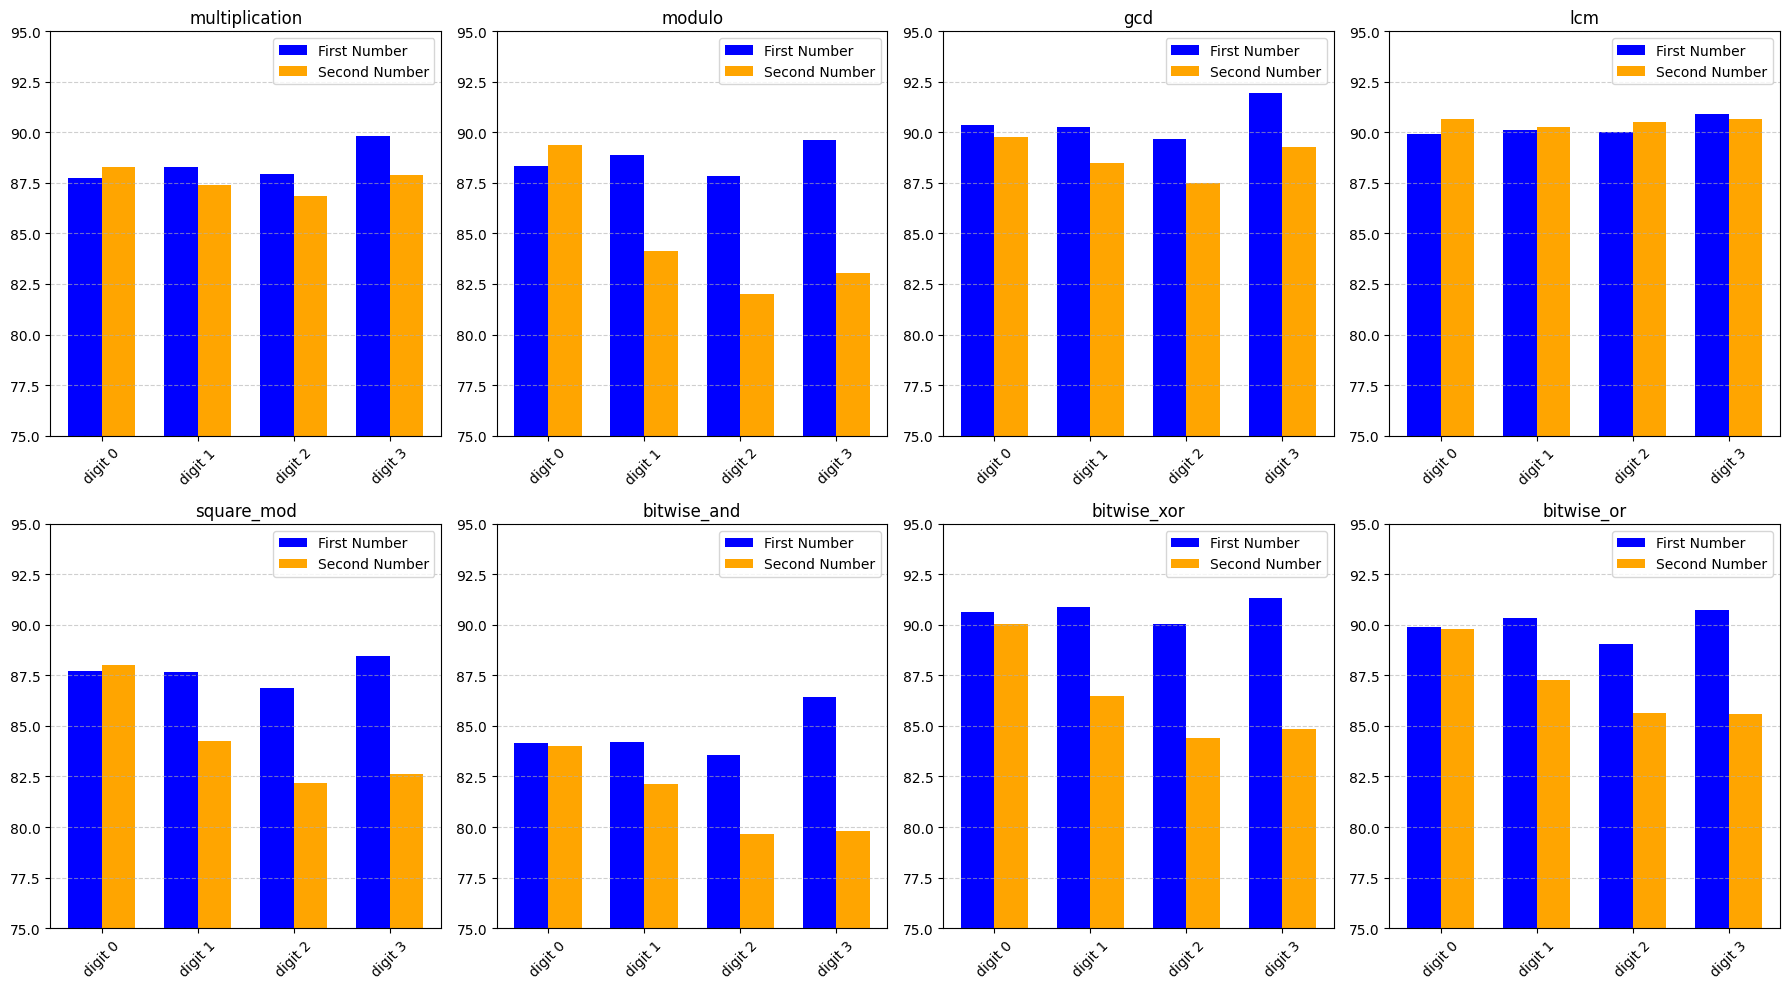

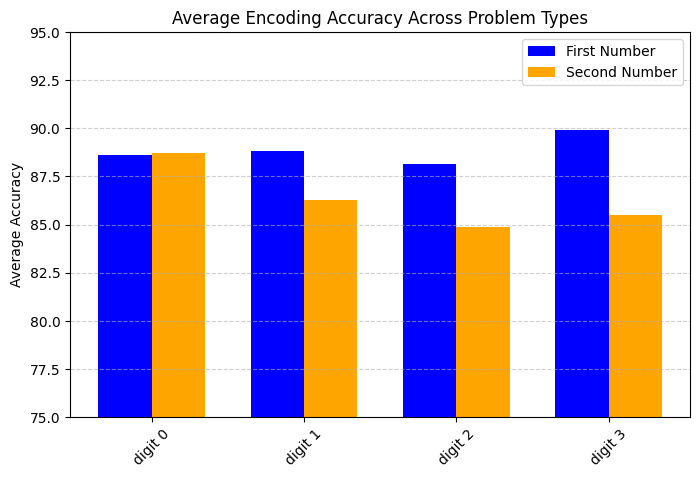

In [59]:
# DO NOT DELETE
average_accuracy_per_pt = {}

digits = list(self.model.encoding_accuracy[problem_types[0]].keys())
problem_types = list(self.model.encoding_accuracy.keys())

for pt in problem_types:
    average_accuracy_per_pt[pt] = {}
    for d in digits:
        average_accuracy_per_pt[pt][d] = [0, 0]
        average_accuracy_per_pt[pt][d][0] = np.mean(self.model.encoding_accuracy[pt][d]["first_number"])*100
        average_accuracy_per_pt[pt][d][1] = np.mean(self.model.encoding_accuracy[pt][d]["second_number"])*100


# Define colors for first and second number
colors = ['blue', 'orange']

# Create subplots (one per problem type)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))  # Adjust grid based on the number of problem types
axes = axes.flatten()  # Flatten to index easier

for i, (problem_type, digits_data) in enumerate(average_accuracy_per_pt.items()):
    ax = axes[i]

    digits = list(digits_data.keys())  # ['digit 0', 'digit 1', ...]
    x = np.arange(len(digits))  # X-axis positions

    first_num = [digits_data[d][0] for d in digits]  # First number accuracies
    second_num = [digits_data[d][1] for d in digits]  # Second number accuracies

    width = 0.35  # Width of bars
    ax.bar(x - width/2, first_num, width, label='First Number', color=colors[0])
    ax.bar(x + width/2, second_num, width, label='Second Number', color=colors[1])

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(digits, rotation=45)
    ax.set_ylim(75, 95)  # Adjust y-axis for better visibility
    ax.set_title(problem_type)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Compute average per digit across all problem types
digits = ['digit 0', 'digit 1', 'digit 2', 'digit 3']
avg_first_number = []
avg_second_number = []

for d in digits:
    first_vals = [average_accuracy_per_pt[pt][d][0] for pt in average_accuracy_per_pt]
    second_vals = [average_accuracy_per_pt[pt][d][1] for pt in average_accuracy_per_pt]
    avg_first_number.append(np.mean(first_vals))
    avg_second_number.append(np.mean(second_vals))

# Plotting
x = np.arange(len(digits))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, avg_first_number, width, label='First Number', color='blue')
ax.bar(x + width/2, avg_second_number, width, label='Second Number', color='orange')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(digits, rotation=45)
ax.set_ylim(75, 95)  # Adjust y-axis for better visibility
ax.set_ylabel("Average Accuracy")
ax.set_title("Average Encoding Accuracy Across Problem Types")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()


SyntaxError: invalid character in identifier (96255774.py, line 11)

In [15]:
wandb.finish() # If there is an active current run, terminate it
config = initialize_default_config()

config["encoder_input_tokens"] = 'all'
config["complexity"] = 3
config["initialize_decoders"] = False
config["symbolic_encoding_layer"] = 5
config["symbolic_decoding_layers"] = [10]

#config["verbose"] = 2
config["epochs_to_print"] = config["num_epochs"]

#config['test_with_non_numerical_rep'] = True
#config['train_model'] = False

config["problem_type"] = ["multiplication", "lcm"]
config["testing_problems"] = ["multiplication", "lcm"]
#config["testing_verbose"] = 2

wandb.init(
    project = "Symbolic LLM - Fine Tune Decoders",
    name    = f"Multiple input tokens",
    config  = config
)
print(f"STARTING NEW EXPERIMENT (run_id = {wandb.run.id})\n\n")
run_experiment(self=self, config=config)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: varun_dhanraj. Use `wandb login --relogin` to force relogin


STARTING NEW EXPERIMENT (run_id = qfjqvsoa)


Number of trainable parameters: 8388608
 -------------- Epoch 0, Loss: 8.625, Score: 0.0  -------------- 
 -------------- Epoch 1, Loss: 8.4375, Score: 0.0  -------------- 
 -------------- Epoch 2, Loss: 9.125, Score: 0.0  -------------- 
 -------------- Epoch 3, Loss: 7.0, Score: 0.0  -------------- 
 -------------- Epoch 4, Loss: 7.15625, Score: 0.0  -------------- 
 -------------- Epoch 5, Loss: 8.1875, Score: 0.0  -------------- 
 -------------- Epoch 6, Loss: 4.53125, Score: 0.0  -------------- 
 -------------- Epoch 7, Loss: 7.8125, Score: 0.0  -------------- 
 -------------- Epoch 8, Loss: 8.25, Score: 0.0  -------------- 
 -------------- Epoch 9, Loss: 6.71875, Score: 0.0  -------------- 
 -------------- Epoch 10, Loss: 6.03125, Score: 0.0  -------------- 
 -------------- Epoch 11, Loss: 6.625, Score: 0.0  -------------- 
 -------------- Epoch 12, Loss: 4.78125, Score: 0.0  -------------- 
 -------------- Epoch 13, Loss: 5.90625, Sc

 -------------- Epoch 116, Loss: 4.09375, Score: 0.0625  -------------- 
 -------------- Epoch 117, Loss: 3.96875, Score: 0.0  -------------- 
 -------------- Epoch 118, Loss: 3.46875, Score: 0.0625  -------------- 
 -------------- Epoch 119, Loss: 4.40625, Score: 0.0625  -------------- 
 -------------- Epoch 120, Loss: 4.375, Score: 0.0  -------------- 
 -------------- Epoch 121, Loss: 4.375, Score: 0.125  -------------- 
 -------------- Epoch 122, Loss: 4.09375, Score: 0.0625  -------------- 
 -------------- Epoch 123, Loss: 2.921875, Score: 0.0625  -------------- 
 -------------- Epoch 124, Loss: 4.09375, Score: 0.0625  -------------- 
 -------------- Epoch 125, Loss: 3.984375, Score: 0.0625  -------------- 
 -------------- Epoch 126, Loss: 3.390625, Score: 0.1875  -------------- 
 -------------- Epoch 127, Loss: 4.65625, Score: 0.25  -------------- 
 -------------- Epoch 128, Loss: 3.765625, Score: 0.0625  -------------- 
 -------------- Epoch 129, Loss: 3.5, Score: 0.0  ----------


KeyboardInterrupt



In [ ]:
for p in self.model.decoders[10].parameters():
    print(p.requires_grad)